## Problem Definition
State: Closing prices of the two stocks (JPM and MSFT) of that day \
Action: Change the weights in one of the two ways: (+0.1, -0.1), (-0.1, +0.1). The initial weights are (0.5, 0.5) \
Next State: Closing prices of the two stocks of the next day \
Reward: Increase or decrease of the daily return compared to the daily return without chaging the weights. \

## Approach
Explore the entire state space and learn about all the transitions between states and rewards associated with transitions. Construct a list of (s, a, r, s') and then run a Q-learning algorithm on the constructed data to get the optimal policy. \

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Creates a list of (s, a, r, s')
def construct_data(close_df):
    data = pd.DataFrame(columns =['s', 'a', 'r', 'sp'])
    for index, row in tqdm(close_df.iterrows()):
        if row["Date"] != "2021-11-05":
            close_prices = (row["JPM"], row["MSFT"])
            action = random.randint(0, 1)
            next_row = close_df.loc[index+1]
            next_close_prices = (next_row["JPM"],  next_row["MSFT"])
            reward = compute_reward(close_prices, action, next_close_prices)
            new_data = {'s': close_prices, 'a': action, 'r': reward * 1000, 'sp': next_close_prices}
            data = data.append(new_data, ignore_index=True)
    return data

In [7]:
JPM = pd.read_csv('JPM.csv', parse_dates=True)
MSFT = pd.read_csv('MSFT.csv', parse_dates=True)
close_df = pd.DataFrame({'Date':JPM['Date'], 'JPM': JPM['Close'], 'MSFT': MSFT['Close']})
print(construct_data(close_df))

7811it [00:22, 345.69it/s]

                                             s  a         r  \
0               (3.708333, 0.8923610000000001)  1  2.592626   
1                         (3.583333, 0.885417)  1 -5.043417   
2                   (3.75, 0.8819440000000001)  1  3.079726   
3               (3.708333, 0.8993059999999999)  0  1.494599   
4                    (4.0, 0.9565969999999999)  0 -1.720372   
5                         (3.916667, 0.953125)  1 -4.044071   
6                  (4.125, 0.9652780000000001)  1  0.692117   
7                              (4.0, 0.942708)  0  1.899175   
8     (4.0833330000000005, 0.9444440000000001)  1  0.165121   
9     (4.1666669999999995, 0.9652780000000001)  0 -4.201450   
10                        (3.916667, 0.947917)  0 -1.796392   
11                 (3.875, 0.9548610000000001)  1  2.150529   
12              (3.791667, 0.9548610000000001)  0  1.114919   
13              (3.916667, 0.9756940000000001)  1  2.313225   
14              (3.916667, 0.9982639999999999)  1  1.10

In [6]:
# Comptues reward given (s, a, s')
def compute_reward(s, a, sp):
    unweighted_daily_returns = np.array([sp[i] / x for i, x in enumerate(s)])
    if a == 0:
        weight_change = np.array([0.1, -0.1])
    else:
        weight_change = np.array([-0.1, 0.1])
    return np.dot(unweighted_daily_returns, weight_change) 

In [18]:
# Find optimal policy using Q-learning (same algorithm for Project 2)
def find_optimal_policy(data):
    alpha = 0.8
    gamma = 0.95  # discount factor
    # map from each state-action pair to the estimated optimal Q-value
    q_opt_estimate_map = {}
    transition_reward_map = {}  # map from (s, a, s') to rewards
    state_transition_map = {}  # map from each state to the next states
    num_states = data.size // 4
    num_actions = 2

    # Iterates over rows of the data to store rewards for each transition and the next states of each state
    for _, row in data.iterrows():
        s = row['s']
        a = row['a']
        r = row['r']
        sp = row['sp']
        state_transition_map[s] = []
        transition_reward_map[(s, a, sp)] = r
        state_transition_map[s] += [sp]
        for a in range(num_actions):
            q_opt_estimate_map[(s, a)] = 0

    num_updates = 5
    # Updates each state-action pair's estimated optimal Q-value iteratively
    for _ in range(num_updates):
        for s, a in q_opt_estimate_map:
            if s not in state_transition_map:
                continue
            for sp in state_transition_map[s]:
                q_opt_estimate_at_next_state = float("-inf")
                # Finds the action that maximizes the estimated Q-value of the next state
                for ap in range(num_actions):
                    if (sp, ap) not in q_opt_estimate_map:
                        q_opt_estimate_at_next_state = 0
                        break
                    if q_opt_estimate_map[(sp, ap)] > q_opt_estimate_at_next_state:
                        q_opt_estimate_at_next_state = q_opt_estimate_map[sp, ap]
                # Updates the Q-value using the Q-learning formula
                q_opt_estimate_map[(s, a)] = (1 - alpha) * \
                    q_opt_estimate_map[(s, a)] + alpha * \
                    (transition_reward_map.get((s, a, sp), 0) +
                     gamma * q_opt_estimate_at_next_state)

    optimal_policy = {}
    # Extract the optimal policy of each state from the estimated optimal Q-value of the state
    for s, a in q_opt_estimate_map:
        if s not in optimal_policy or q_opt_estimate_map[(s, a)] > q_opt_estimate_map[(s, optimal_policy[s])]:
            optimal_policy[s] = a
    return optimal_policy

In [28]:
# Computes the total return that could be generated by using the optimal weights (policy)
def compute_weighted_total_return(close_df, optimal_policy):
    prev_weight = [0.5, 0.5]
    total_return = 1
    JPM_weight_history = [0.5]
    MSFT_weight_history = [0.5]
    for index, row in tqdm(close_df.iterrows()):
        if row["Date"] != "2021-11-05":
            s = (row["JPM"], row["MSFT"])
            a = optimal_policy[s]
            next_row = close_df.loc[index+1]
            sp = (next_row["JPM"],  next_row["MSFT"])
            if a == 0:
                weight = np.add(prev_weight, [0.1, -0.1])
            else:
                weight = np.add(prev_weight, [-0.1, 0.1])
            JPM_weight_history.append(weight[0])
            MSFT_weight_history.append(weight[1])
            prev_pl = np.dot(prev_weight, s)
            pl = np.dot(weight, sp)
            daily_return = pl / prev_pl
            prev_weight = weight
            total_return *= daily_return
    return (total_return, JPM_weight_history, MSFT_weight_history) 

In [20]:
# Computes the total return without using the weight optimization. This is the baseline.
def compute_unweighted_total_return(close_df):
    last_date = "2021-11-05"
    weight = [0.5,0.5]
    total_return = 1
    for index, row in tqdm(close_df.iterrows()):
        if row["Date"] != last_date:
            s = (row["JPM"], row["MSFT"])
            next_row = close_df.loc[index+1]
            sp = (next_row["JPM"],  next_row["MSFT"])
            prev_pl = np.dot(weight, s)
            pl = np.dot(weight, sp)
            daily_return = pl / prev_pl
            total_return *= daily_return
    return total_return

In [29]:
JPM = pd.read_csv('JPM.csv', parse_dates=True)
MSFT = pd.read_csv('MSFT.csv', parse_dates=True)
close_df = pd.DataFrame({'Date':JPM['Date'], 'JPM': JPM['Close'], 'MSFT': MSFT['Close']})
data = construct_data(close_df)
optimal_policy = find_optimal_policy(data)
weighted_total_return, JPM_weight_history, MSFT_weight_history = compute_weighted_total_return(close_df, optimal_policy)
unweighted_total_return = compute_unweighted_total_return(close_df)
print("Total return if unweighted: ", unweighted_total_return)
print("Total return if weight is optimized: ", weighted_total_return)

7811it [00:26, 297.71it/s]
7811it [00:02, 2772.51it/s]
7811it [00:02, 3290.31it/s]

Total return if unweighted:  109.57259948173066
Total return if weight is optimized:  1029.8363409955123


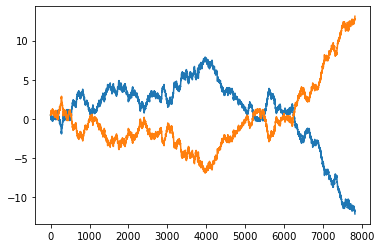

In [31]:
'''
You can see that it is better to have a long position for JPM and a short position for MSFT for the first half. 
But after that period, it is better to have a long position for MSFT and a short position for JPM.
''' 
plt.plot(JPM_weight_history)
plt.plot(MSFT_weight_history)
plt.show()